<a href="https://colab.research.google.com/github/afazil2021/animal-image-classification/blob/main/image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# End to End Image Classification using TensorFlow 2.0 

This notebook builds an end to end multi-class image classifier using TensorFlow 2.0 and TensorFlow Hub (Transfer Learning). 

##1. Problem 

Identify the breed of a dog given an image of a dog. 

If someone was to provide you with an image of a dog, can you feed it into a model and classify the breed? 

##2. Data 

A large amount of images of dogs followed by their appropriate id tag. 

##3. Evaluation 

Technically we are looking at **Multi Class Log Loss** - However in simple terms it's really for each image of a dog can we predict the probability for each breed it identifies? 

##4. Features 

Some information about the data: 
* We're dealing with images (unstructured data) so it's best to use deep learning/transfer learning. 
* There are 120 different breeds of dogs (so there are 120 different classes). 
* There are around 10K+ images in the training set (They have labels) 
* There are around 10K+ images in the testing set (They have no labels - we are trying to predict them)


Unzip the data using terminal to the same directory....

In [ ]:
#!unzip "drive/MyDrive/image-classification-data/dog-breed-identification.zip" -d "drive/MyDrive/image-classification-data/"

# Setting up Workspace 

* Import TensorFlow 2.x 
* Import TensorFlow Hub 
* Setup a GPU 

In [1]:
# Import TensorFlow into Colab
import tensorflow as tf 
# import tensorflow hub 
import tensorflow_hub as hub 

# find the version of tensortflow 
print("TF Hub Version:", tf.__version__)
print("TF Version:", hub.__version__)

# print a boolean if it is > 2
current_version = tf.__version__.replace(".","") # remove the full stops in str
# then turn into a int 
current_version = int(current_version)
if current_version > 200: 
  print("You can continue on")
else: 
  print("you need to upgrade your colab space to be Tensorflow 2.0")

TF Hub Version: 2.4.1
TF Version: 0.11.0
You can continue on


In [2]:
# check for the GPU availablility
print("GPU", "is available" if tf.config.list_physical_devices("GPU") else "None avilable - change in runtime tab")

GPU is available


# Transform Data into Tensors

As with all machine learning models -dat amust be in muerical format - so we are turning these images into Tensors (A matrix....)

Start by accessing the data and accessing the labels

In [3]:
# check out the labels of the data 
import pandas as  pd 
labels_csv = pd.read_csv("/content/drive/MyDrive/image-classification-data/labels.csv")
print(labels_csv.describe())
print(labels_csv.head())

                                      id               breed
count                              10222               10222
unique                             10222                 120
top     c47bd2467bbecfdd7ebb15abcdd9ba69  scottish_deerhound
freq                                   1                 126
                                 id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever


In [ ]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


Finding out the different breed counts in the dataset

In [4]:
labels_csv['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
brabancon_griffon        67
golden_retriever         67
eskimo_dog               66
briard                   66
Name: breed, Length: 120, dtype: int64

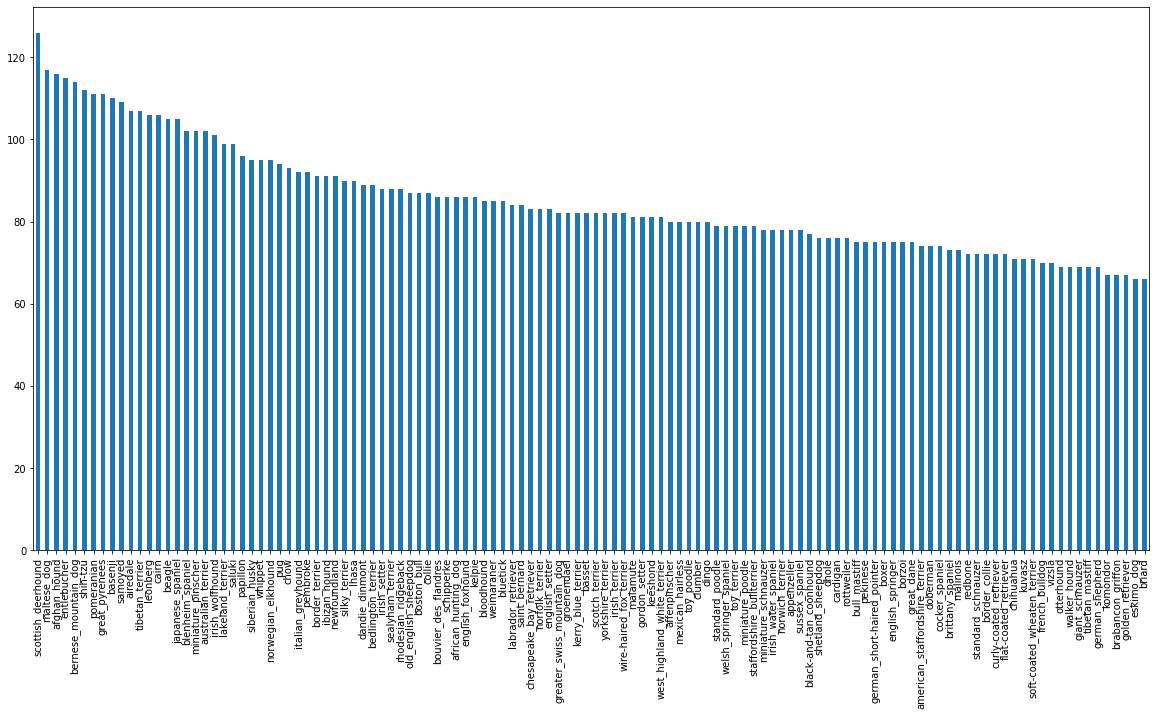

In [5]:
labels_csv['breed'].value_counts().plot.bar(figsize = (20,10))

In [6]:
# Find out what the median value is over each class 
labels_csv['breed'].value_counts().median()

82.0

In [ ]:
# So we have around 82 - google says you need a minimum of 10 per class - for an image classifier - we have around 82 per class so it's not too bad

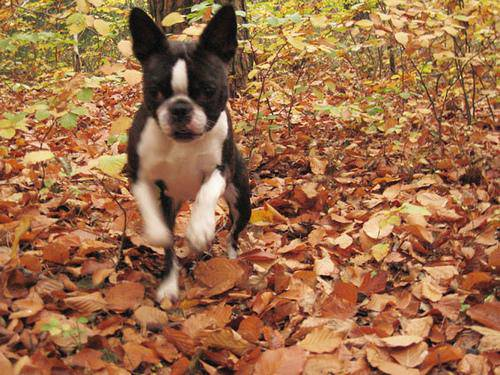

In [8]:
# View an image within this notebook 
from IPython.display import Image 
Image('drive/My Drive/image-classification-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg')

# Getting Images and Their Labels 

Attain a list of all out image file pathnames

In [9]:
labels_csv.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [15]:
# create pathnames from image ID's 
filenames = ['drive/My Drive/image-classification-data/train/' + fname +'.jpg' for fname in labels_csv['id']]

In [16]:
filenames[:5]

['drive/My Drive/image-classification-data/train/000bec180eb18c7604dcecc8fe0dba07.jpg',
 'drive/My Drive/image-classification-data/train/001513dfcb2ffafc82cccf4d8bbaba97.jpg',
 'drive/My Drive/image-classification-data/train/001cdf01b096e06d78e9e5112d419397.jpg',
 'drive/My Drive/image-classification-data/train/00214f311d5d2247d5dfe4fe24b2303d.jpg',
 'drive/My Drive/image-classification-data/train/0021f9ceb3235effd7fcde7f7538ed62.jpg']

In [18]:
# check if file names matches actual image files in training folder 
import os 
if len(os.listdir('drive/My Drive/image-classification-data/train/')) == len(filenames): 
  print("Match")

Match


We've attained the training image filepaths in a list, we can now prepare the labels for the data. 

In [19]:
import numpy as np 
labels  = labels_csv['breed'].to_numpy()

In [25]:
labels
# an array of strings

array(['boston_bull', 'dingo', 'pekinese', ..., 'airedale',
       'miniature_pinscher', 'chesapeake_bay_retriever'], dtype=object)

In [21]:
len(labels)

10222

In [24]:
# see if the number of labels matches the number of images 
if len(labels) == len(filenames): 
  print("number of labels matches filenames")

number of labels matches filenames


In [27]:
# find the unique labelled values in the labels array 
unique_breeds = np.unique(labels)
len(unique_breeds)

120

In [28]:
# trun every label into a boolean array 
boolean_labels = [label == unique_breeds for label in labels]

In [29]:
boolean_labels

[array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False,  True, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,
        False, False, False]),
 array([False, False, False, False, False, Fal

In [32]:
# truning the array into ingergers 
print(labels[0])
print(np.where(unique_breeds ==labels[0]))
print(boolean_labels[0]. argmax())

boston_bull
(array([19]),)
19
